In [1]:
import sys
sys.path.append('/tigress/kendrab/python_pkgs')

import matplotlib.pyplot as plt
import numpy as np
from dataframework.src.datasets.vpicdataset import VPICDataset
import h5py
import matplotlib.animation as animation

In [2]:
def mtail_transform(sim_data):  # TODO FIX THIS  # From 1d_sampling notebook
    """ The geometry of the simulation is different wrt the magnetotail. Keeping y the same, bx will be
    the mtail's 'bz' and bz will be the mtails 'bx'.
    This function is for simulations WITHOUT y spatial dimensions
    THIS IS NOT A GOOD GENERALIZABLE FUNCTION!!!! REUSE WITH EXTREME CAUTION!!!
    This is for rxn geometry in vpic with Bz positive for x>0 and negative for x<0.
    If it is the opposite, need to do a different transform to get the reconnection to line up w/ gsm directions
    """
    # vpic +x -> GSM +z
    # vpic +z -> GSM +x
    # vpic +y -> GSM -y
    # meshes now in order x, z instead of z, x (renaming coords)
    # for vector variables ax, ay, az:
    # rename ax -> az_mms
    # ay_mms = -ay
    # rename az -> ax_mms
    sim_data.variables['bz_mms'] = sim_data.variables.pop('bx')
#    sim_data.variables['bz_mms_smooth'] = sim_data.variables.pop('bx_smooth')
    sim_data.variables['by_mms'] = sim_data.variables.pop('by')
    sim_data.variables['by_mms'].data *= -1
    sim_data.variables['bx_mms'] = sim_data.variables.pop('bz') 
#    sim_data.variables['bx_mms_smooth'] = sim_data.variables.pop('bz_smooth') 
    sim_data.variables['vx_mms'] = sim_data.variables.pop('vz')
    sim_data.variables['jy_mms'] = sim_data.variables.pop('jy')
    sim_data.variables['jy_mms'].data *= -1    
    sim_data.variables['ez_mms'] = sim_data.variables.pop('ex')
    sim_data.variables['ey_mms'] = sim_data.variables.pop('ey')
    sim_data.variables['ey_mms'].data *= -1
    sim_data.variables['ex_mms'] = sim_data.variables.pop('ez') 
    
    # update variable names for everyone
    for key in sim_data.variables.keys():
        print(f"label {sim_data.variables[key].label} becoming {key}")
        sim_data.variables[key].label = key

In [3]:
file_num = 9  # so it is part of the testing dataset
file = f'/scratch/gpfs/kendrab/dataset_vpic_runs/perturbed/21032023/output{file_num}/data.h5'
write_path = f'/tigress/kendrab/21032023/{file_num}'

zooms = [[-np.inf,np.inf], [-np.inf, np.inf]]
kwargs = {'get_vars' : ['bx','by','bz','jy','vz','ex','ey','ez']}

In [4]:
sim_dset = VPICDataset(vpicfiles=[file,''], **kwargs)
zoomed_dset = sim_dset.ndslice(zooms=zooms)


NO PARAMS ADDED, FUNCTIONALIITY NOT ADDED YET!!!! SORRY
parameter filename = /scratch/gpfs/kendrab/dataset_vpic_runs/perturbed/21032023/output9/data.h5
Added bx Variable
Added by Variable
Added bz Variable
Added jy Variable
Added vz Variable
Added ex Variable
Added ey Variable
Added ez Variable


In [5]:
print(dir(zoomed_dset))
zoomed_dset.calc_fluxfn(b1_name='bz', b2_name='bx')  # found the plasmoids
mtail_transform(zoomed_dset)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_param', '_add_var', '_get_params', '_init_datapkg', '_init_file', '_init_vpicfile', 'add_param', 'add_var', 'bounds', 'calc_fluxfn', 'default_mesh', 'export', 'find_structures', 'ndslice', 'params', 'timeseries', 'variables']
Added flux_fn Variable
label flux_fn becoming flux_fn
label bx becoming bz_mms
label by becoming by_mms
label bz becoming bx_mms
label vz becoming vx_mms
label jy becoming jy_mms
label ex becoming ez_mms
label ey becoming ey_mms
label ez becoming ex_mms


/tmp/ipykernel_4056301/1438941401.py:12: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in pic.collections:


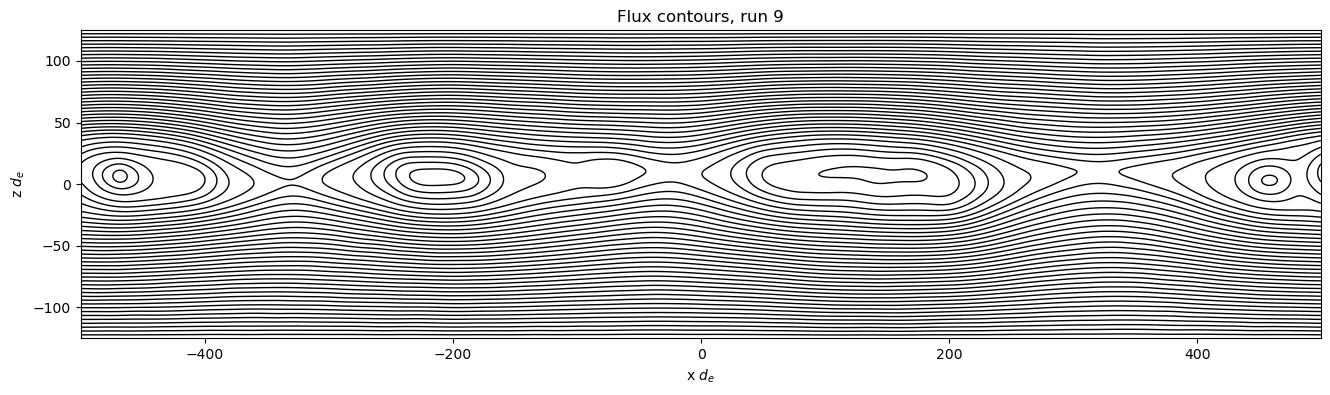

In [6]:
fig, ax = plt.subplots(figsize=(16,4))

flux_fn = zoomed_dset.variables['flux_fn']
X,Y = np.meshgrid(*flux_fn.mesh, indexing='ij')
levels = np.linspace(np.min(flux_fn.data), np.max(flux_fn.data), 40)
ax.set(title="Flux contours, run 9", xlabel=r"x $d_e$", ylabel=r"z $d_e$")
pic = ax.contour(X, Y, flux_fn.data[0], levels=levels, colors='black', linewidths=1) # dashed lines mean flux_fn negative


def animate(i):
    global pic  # why do I need to global this I am confuseddddd
    for c in pic.collections:
        c.remove()
    pic = ax.contour(X, Y, flux_fn.data[i], levels=levels, colors='black', linewidths=1)
    return pic,

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=flux_fn.data.shape[0])
ani.save(f'/tigress/kendrab/analysis-notebooks/model_outs/04-08-23/results_pics_A144933/run{file_num}movie_full.mp4')

plt.show()